# Module 3 - Algorithm auditing: Accuracy, Fairness and Interpretability 


### Assignment overview

In this assignment, you will be asked to evaluate a set of trained classifiers for accuracy, fairness and transparency. The classifiers have been trained on the [NIJ Recidivism Challenge Dataset](https://nij.ojp.gov/funding/recidivism-forecasting-challenge) to predict whether or not an individual will be arrested for a new crime within 3 years after being released on parole. 

The assignment is modeled after “Accuracy, Fairness, and Interpretability of Machine Learning Criminal Recidivism Models, by Eric Ingram, Furkan Gursoy, Ioannis A. Kakadiaris (https://arxiv.org/abs/2209.14237). 

For this assignment, it is possible to work in **groups of up to 2 students**. 

### Group members
Leave blanks if group has less than 2 members:
- Student 1: Luna Gulec
- Student 2: Athena Wong


### Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:
1. Describe different fairness metrics, such as statistical parity, equal opportunity and equal accuracy 
2. Discuss fairness and fairness metrics from the perspective of multiple stakeholders 
3. Define objective functions based on fairness metrics  
4. Evaluate a model’s transparency using strategies such as global surrogate models, permutation feature importance, and Shapley Additive Explanations (SHAP) 
5. Evaluate common machine learning models based on their accuracy, fairness and interpretability 
6. Describe how metrics such as accuracy and fairness need to be balanced for a trained model to have acceptable accuracy and low bias 

## Import Libraries:

In [1]:
# pip install 'aif360[AdversarialDebiasing]'
# pip install eli5
# pip install --upgrade numpy matplotlib
# pip install 'aif360[Reductions]'

In [2]:
# May require installation of additional libraries like aif360 and eli5

import pandas as pd
import numpy as np
import joblib

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
)

import matplotlib.pyplot as plt
import eli5
from sklearn.inspection import permutation_importance

pip install 'aif360[inFairness]'


# Part 1: Getting started:

Before starting this assignment, we ask you to read the paper it has been modeled after, to get an idea of the problem we are working on: https://arxiv.org/abs/2209.14237

You can also review the original dataset source [here](https://nij.ojp.gov/funding/recidivism-forecasting-challenge). The website includes a lot of information on the dataset and a detailed description of each of its columns (look for Appendix 2: Codebook).

Now that you have familiarized with the problem, you know that the goal is predicting the binary variable `Recidivism_Within_3years`, which indicates whether or not the person has committed a new felony or misdemeanour within 3 years from the beginning of parole supervision. 

The National Institute of Justice’s (NIJ) obviously would want to deploy a highly accurate predictive model, to make sure that only deserving people get released on parole. Unfortunately, the existence of bias in the training set (typically historical or representation bias) makes it very likely to end up with an unfair classifier, that is, a classifier that produces different results for different protected classes of population.

Your job is to evaluate 4 classifiers, pre-trained and provided to you. This is called **algorithm auditing:** you are not the designer of the model, but you are in charge of evaluating its performance. Algorithm auditing can focus on various metrics and populations of interest, but in this case we will focus on evaluating **accuracy, fairness and transparency** of each algorithm.

To begin, load the dataset and classifiers by running the cells below:

In [3]:
train_df = pd.read_csv("data/training_set.csv")
test_df = pd.read_csv("data/testing_set.csv")

In [4]:
test_df.head()

,Unnamed: 0,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,...,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample
0,3735,3848,M,BLACK,48 or older,1,No,6.0,Standard,High School Diploma,...,0.0,0.0,1.00000,0.299385,No,No,No,No,No,0
1,5039,5174,M,BLACK,48 or older,20,No,2.0,Specialized,High School Diploma,...,0.0,0.0,1.00000,1.544397,No,Yes,No,No,Yes,1
2,16027,16485,F,WHITE,33-37,10,NaN,6.0,High,High School Diploma,...,0.0,0.0,0.51049,1.277098,No,No,No,No,No,1
3,18863,19486,F,WHITE,43-47,11,NaN,5.0,Standard,High School Diploma,...,0.0,0.0,1.00000,1.006198,No,No,No,No,No,1
4,14013,14408,M,WHITE,33-37,14,No,4.0,Standard,High School Diploma,...,0.0,0.0,1.00000,1.318592,No,No,No,No,No,1


In [5]:
# Separating features and target
X_train, y_train = (
    train_df.drop(columns=["Recidivism_Within_3years"]),
    train_df["Recidivism_Within_3years"],
)
X_test, y_test = (
    test_df.drop(columns=["Recidivism_Within_3years"]),
    test_df["Recidivism_Within_3years"],
)

In [6]:
# Loading classifiers
logreg_model  = joblib.load("models_for_A3/NIJ_logreg.joblib")
rf_model      = joblib.load("models_for_A3/NIJ_rf.joblib")
tree_model    = joblib.load("models_for_A3/NIJ_tree.joblib")
xgboost_model = joblib.load("models_for_A3/NIJ_xgboost.joblib")

/opt/miniconda3/envs/dsci430/lib/python3.10/pickle.py:1718: UserWarning: [20:39:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1767713854601/work/src/gbm/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


# Part 2: Classifiers' Accuracy (and other performance metrics):

First, we will evaluate each classifier's accuracy, together with other performance metrics that help us understanding how reliable the classifier's answers are. In addition to accuracy, we will use, **precision, recall and F1 score.**

### Question 1

Can you provide definition and formula for accuracy, precision, recall and F1 score, as a function of True Positives (TP), True Negatives (TN), False Positives (FP) and False Negatives (FN)?

It may help you use this table for reference:

<img src="ConfMatrix.png" alt="drawing" width="500"/>

Here, we are giving you the definition of AUC, as a reminder and example (note that the other metrics will need the formula):

**AUC:** AUC stands for Area Under the ROC curve. The ROC (receiver operating characteristic) curve is a plot of the recall and false positive rate of a classifier for different classification thresholds (see [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) for more details). AUC values go between 0 and 1. Higher values are more desirable as they indicate that the classifier is good at avoiding both false positives and false negatives. A value of 0.5 for a binary classification indicates that the classifier is no better at predicting the outcome than random guessing.

**Add remaining definitions and formulas here**
**Accuracy:** Accuracy is the overall correctness. **Accuracy = (TP+TN)/total**

**Recall:** Recall measures how often a machine learning model correctly identifies positive instances (true positives) from all the actual positive samples in the dataset. **Recall = TP/(TP+FN)**

**Precision:** Precision measures how often a machine learning model correctly predicts the positive class. **Precision = TP/(TP+FP)** 

**F1 Score:** F1 Score is the harmonic mean of precision and recall. **F1 Score = 2 × (Precision × Recall) / (Precision + Recall)**


### Question 2

For every classifier given, calculate and report accuracy, precision, recall and F1 score on the test set. For ease of visualization and comparison, we will summarize these results in this dictionary:

In [7]:
results_dict = {}

There are different options available to us to compute fairness metrics, such as the many functions included in sklearn. For this exercise, however, we will focus on working with the [aif360](https://aif360.readthedocs.io/en/stable/Getting%20Started.html) library, an open source library designed specifically to examine and mitigate discrimination and bias in machine learning models.

Let's see in an example how we can use aif360 to compute standard performance metrics. We will start with the Random Forest model.

In [8]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# When using aif360, the target has to be numerical, so we will start by converting our target column. Since we are 
# only interested in the metrics from the test set, we will convert only the test target

# Define your mapping
label_map = {"No": 0, "Yes": 1}

# Convert y_test
y_test_num = y_test.map(label_map)

# Since aif360 focuses on fairness, it needs us to identify the protected attribute we will use to segment the population.
protected_attr = 'pipeline-2__Race_WHITE'   

# aif360 can not handle Nans - we must impute before converting. For this purpose, I can use the transformer included in 
# the RF model
X_test_array = rf_model.named_steps['ct'].transform(X_test)

feature_names = rf_model.named_steps['ct'].get_feature_names_out()

X_test_transformed = pd.DataFrame(X_test_array, columns=feature_names, index=X_test.index)

# Locate protected attribute column in transformed test set.
protected_idx = X_test_transformed.columns.get_loc(protected_attr)

# Now that we have collected all this information, we can create a BinaryLabelDataset,
# aif360 base class for all structured datasets with binary labels - like ours!
# https://aif360.readthedocs.io/en/stable/modules/generated/aif360.datasets.BinaryLabelDataset.html#aif360.datasets.BinaryLabelDataset

aif_test = BinaryLabelDataset(
    favorable_label=1, # Being identified as not having committed a crime is the favorable outcome
    unfavorable_label=0,
    df=pd.concat([X_test_transformed, y_test_num], axis=1),
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)


In [9]:
# Now, we need to do a similar process and create a BinaryLabelDataset for the predictions of the Random Forest model

# First, we'll get the predictions and convert them to 0 and 1
y_pred = rf_model.predict(X_test)
y_pred_num = pd.Series(y_pred, index=y_test.index).map(label_map)

# Then, we will create a copy of the transformed test feature matrix and attach the predictions to it
pred_df = X_test_transformed.copy()
pred_df[y_test.name] = y_pred_num

# Finally, we piece everything together in a BinaryLabelDataset 
aif_pred = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pred_df,
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)

In [10]:
# We are now ready to compute some metrics using aif_test (our ground truth) and aif_pred (our predictions)
classified_metric_rf = ClassificationMetric(
    aif_test,
    aif_pred,
    unprivileged_groups=[{protected_attr: 0}],
    privileged_groups=[{protected_attr: 1}]
)

precision = classified_metric_rf.precision()
recall = classified_metric_rf.recall()

# aif360 does not have a function foro F1 - we will compute F1 manually
if (precision + recall) > 0:
    f1 = 2 * (precision * recall) / (precision + recall)
else:
    f1 = 0.0

# Saving results in the dictionary
results_dict["RandomForest"] = {
    "accuracy": format(classified_metric_rf.accuracy(), ".3f"),
    "precision": format(precision, ".3f"),
    "recall": format(recall, ".3f"),
    "f1_score": format(f1, ".3f"),
}


In [11]:
# We can check our results
pd.DataFrame(results_dict)

,RandomForest
accuracy,0.720
precision,0.740
recall,0.788
f1_score,0.763


Repeat the steps above for the logistic regression, decision tree, and xgboost model, and add the results to the dictionary.

### LogReg Model:

In [12]:
# adapted from the above 3 cells, editing for the predictions of the Logistic Regression model

# First, we'll get the predictions and convert them to 0 and 1
y_pred = logreg_model.predict(X_test)
y_pred_num = pd.Series(y_pred, index=y_test.index).map(label_map)

# Then, we will create a copy of the transformed test feature matrix and attach the predictions to it
pred_df = X_test_transformed.copy()
pred_df[y_test.name] = y_pred_num

# Finally, we piece everything together in a BinaryLabelDataset 
aif_pred = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pred_df,
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)

# We are now ready to compute some metrics using aif_test (our ground truth) and aif_pred (our predictions)
classified_metric_lr = ClassificationMetric(
    aif_test,
    aif_pred,
    unprivileged_groups=[{protected_attr: 0}],
    privileged_groups=[{protected_attr: 1}]
)

precision = classified_metric_lr.precision()
recall = classified_metric_lr.recall()

# compute F1 manually
if (precision + recall) > 0:
    f1 = 2 * (precision * recall) / (precision + recall)
else:
    f1 = 0.0

# Saving results in the dictionary
results_dict["LogisticRegression"] = {
    "accuracy": format(classified_metric_lr.accuracy(), ".3f"),
    "precision": format(precision, ".3f"),
    "recall": format(recall, ".3f"),
    "f1_score": format(f1, ".3f"),
}

### Decision Tree Model:

In [13]:
# adapted from the above RF cells, editing for the predictions of the Decision Tree model

# First, we'll get the predictions and convert them to 0 and 1
y_pred = tree_model.predict(X_test)
y_pred_num = pd.Series(y_pred, index=y_test.index).map(label_map)

# Then, we will create a copy of the transformed test feature matrix and attach the predictions to it
pred_df = X_test_transformed.copy()
pred_df[y_test.name] = y_pred_num

# Finally, we piece everything together in a BinaryLabelDataset 
aif_pred = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pred_df,
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)

# We are now ready to compute some metrics using aif_test (our ground truth) and aif_pred (our predictions)
classified_metric_dt = ClassificationMetric(
    aif_test,
    aif_pred,
    unprivileged_groups=[{protected_attr: 0}],
    privileged_groups=[{protected_attr: 1}]
)

precision = classified_metric_dt.precision()
recall = classified_metric_dt.recall()

# compute F1 manually
if (precision + recall) > 0:
    f1 = 2 * (precision * recall) / (precision + recall)
else:
    f1 = 0.0

# Saving results in the dictionary
results_dict["DecisionTree"] = {
    "accuracy": format(classified_metric_dt.accuracy(), ".3f"),
    "precision": format(precision, ".3f"),
    "recall": format(recall, ".3f"),
    "f1_score": format(f1, ".3f"),
}

### XGBoost Model:

In [14]:
# adapted from the above 3 cells, editing for the predictions of the Logistic Regression model

# First, we'll get the predictions and convert them to 0 and 1
y_pred = xgboost_model.predict(X_test)
# y_pred_num = pd.Series(y_pred, index=y_test.index).map(label_map)

# Then, we will create a copy of the transformed test feature matrix and attach the predictions to it
pred_df = X_test_transformed.copy()
pred_df[y_test.name] = y_pred

# Finally, we piece everything together in a BinaryLabelDataset 
aif_pred = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pred_df,
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)

# We are now ready to compute some metrics using aif_test (our ground truth) and aif_pred (our predictions)
classified_metric_xgb = ClassificationMetric(
    aif_test,
    aif_pred,
    unprivileged_groups=[{protected_attr: 0}],
    privileged_groups=[{protected_attr: 1}]
)

precision = classified_metric_xgb.precision()
recall = classified_metric_xgb.recall()

# compute F1 manually
if (precision + recall) > 0:
    f1 = 2 * (precision * recall) / (precision + recall)
else:
    f1 = 0.0

# Saving results in the dictionary
results_dict["XGBoost"] = {
    "accuracy": format(classified_metric_xgb.accuracy(), ".3f"),
    "precision": format(precision, ".3f"),
    "recall": format(recall, ".3f"),
    "f1_score": format(f1, ".3f"),
}

In [15]:
# checking updated results_dict
pd.DataFrame(results_dict)

,RandomForest,LogisticRegression,DecisionTree,XGBoost
accuracy,0.720,0.709,0.707,0.741
precision,0.740,0.767,0.699,0.745
recall,0.788,0.708,0.858,0.833
f1_score,0.763,0.736,0.771,0.787


### Question 3

For every classifier given, plot the confusion matrices on training and test set. Here is another function you will find helpful for this task: [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

#### Confusion Matrix - logistic regression:

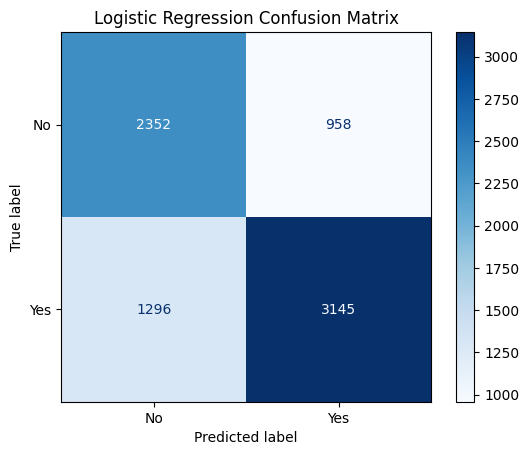

In [16]:
# Use confusion_matrix to plot your result here
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_lr = logreg_model.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=["No", "Yes"])
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["No", "Yes"])
disp_lr.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


In [17]:
# As a sanity check, it is a good idea to compare these results with the ones we would get using aif360
# If they don't match, something went wrong
classified_metric_lr.binary_confusion_matrix(privileged=None)

{'TP': np.float64(3145.0),
 'FP': np.float64(958.0),
 'TN': np.float64(2352.0),
 'FN': np.float64(1296.0)}

#### Confusion Matrix - random forest:

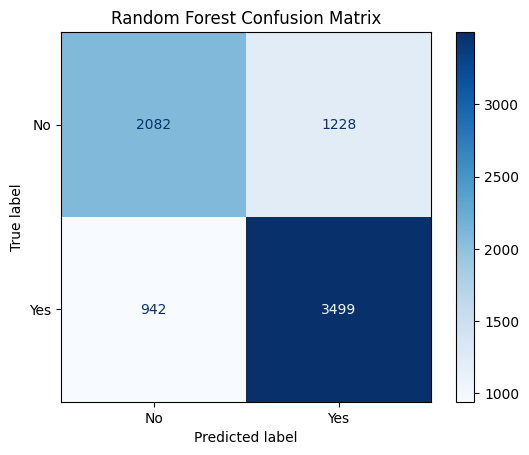

In [18]:
# Use confusion_matrix to plot your result here
y_pred_rf = rf_model.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["No", "Yes"])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No", "Yes"])
disp_rf.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

In [19]:
classified_metric_rf.binary_confusion_matrix(privileged=None)

{'TP': np.float64(3499.0),
 'FP': np.float64(1228.0),
 'TN': np.float64(2082.0),
 'FN': np.float64(942.0)}

#### Confusion Matrix - decision tree:

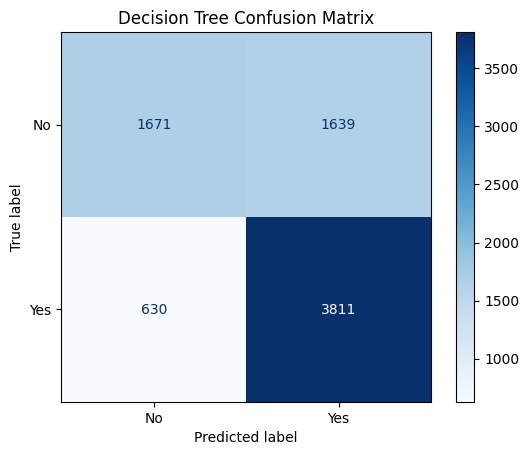

In [20]:
# Use confusion_matrix to plot your result here
y_pred_dt = tree_model.predict(X_test)
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=["No", "Yes"])
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["No", "Yes"])
disp_dt.plot(cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

In [21]:
classified_metric_dt.binary_confusion_matrix(privileged=None)

{'TP': np.float64(3811.0),
 'FP': np.float64(1639.0),
 'TN': np.float64(1671.0),
 'FN': np.float64(630.0)}

#### Confusion Matrix XGBoost:

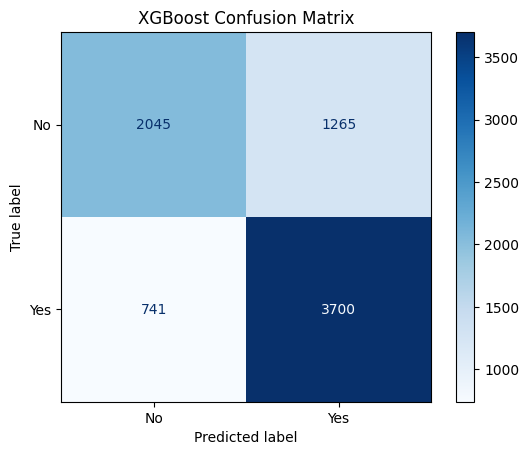

In [22]:
# Use confusion_matrix to plot your result here

y_pred_xgb_numeric = xgboost_model.predict(X_test)

# convert numeric predictions back to strings to match y_test
reverse_label_map = {0: "No", 1: "Yes"}
y_pred_xgb_strings = pd.Series(y_pred_xgb_numeric.astype(int)).map(reverse_label_map)

cm_xgb = confusion_matrix(y_test, y_pred_xgb_strings, labels=["No", "Yes"])
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["No", "Yes"])
disp_xgb.plot(cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()

In [23]:
classified_metric_xgb.binary_confusion_matrix(privileged=None)

{'TP': np.float64(3700.0),
 'FP': np.float64(1265.0),
 'TN': np.float64(2045.0),
 'FN': np.float64(741.0)}

### Question 4

Based on the results obtained so far, answer the following questions, providing an explanation and trying to base your decision on multiple metrics:
- Which classifiers would you choose for deployment?
- Which classifier is the most "severe" (a.k.a. classifies more people as at risk of committing another crime within 3 years)?
- Which classifier is the most cautious (a.k.a. classifies less people as at risk of committing another crime within 3 years)?

**Your answer here**

Compiling the above results:
| Model               | TP   | FP   | TN   | FN   |
|---------------------|------|------|------|------|
| Logistic Regression | 3145 |  958 | 2352 | 1296 |
| Random Forest       | 3499 | 1228 | 2082 |  942 |
| Decision Tree       | 3811 | 1639 | 1671 |  630 |
| XGBoost             | 3700 | 1265 | 2045 |  741 |

Total = TP + FP + TN + FN = 7751

Accuracy = (TP + TN)/total
- Logistic Regression: (3145 + 2352)/7751 = 0.7092
- Random Forest: (3499 + 2082)/7751 = 0.7200
- Decision Tree: (3811 + 1671)/7751 = 0.7073 _<- lowest accuracy_
- XGBoost: (3700 + 2045)/7751 = 0.7412 _<- highest accuracy_

Recall = TP/(TP + FN)
- Logistic Regression: 3145 / (3145 + 1296) = 0.7082 _<- lowest recall_
- Random Forest: 3499 / (3499 + 942) = 0.7879
- Decision Tree: 3811 / (3811 + 630) = 0.8581 _<- highest recall_
- XGBoost: 3700 / (3700 + 741) = 0.8331

Precision = TP/(TP + FP)
- Logistic Regression: 3145 / (3145 + 958) = 0.7665 _<- highest precision_
- Random Forest: 3499 / (3499 + 1228) = 0.7402
- Decision Tree: 3811 / (3811 + 1639) = 0.6993 _<- lowest precision_
- XGBoost: 3700 / (3700 + 1265) = 0.7452

F1 Score = 2 × (Precision × Recall) / (Precision + Recall)
- Logistic Regression: 2 × (0.7665 × 0.7082) / (0.7665 + 0.7082) = 0.736 _<- lowest f1 score_
- Random Forest: 2 × (0.7402 × 0.7879) / (0.7402 + 0.7879) = 0.763
- Decision Tree: 2 × (0.6993 × 0.8581) / (0.6993 + 0.8581) = 0.770
- XGBoost: 2 × (0.7452 × 0.8331) / (0.7452 + 0.8331) = 0.787 _<- highest f1 score_

**1. Which classifiers would you choose for deployment?**
I would choose XGBoost for deployment because it achieves the highest accuracy (0.741) and the highest F1 score (0.787), indicating the best overall balance between precision and recall. While the Decision Tree has the highest recall, it produces many more false positives. Logistic Regression is more cautious but misses too many true recidivists. XGBoost provides a strong middle ground by capturing a high proportion of actual reoffenders while keeping false positives lower than the Decision Tree. In a criminal justice setting, this balance is important to protect public safety without unfairly over-penalizing individuals.

**2. Which classifier is the most "severe" (a.k.a. classifies more people as at risk of committing another crime within 3 years)?**
Predicted Yes = TP + FP
- Logistic Regression: 3145 + 958 = 4103
- Random Forest: 3499 + 1228 = 4727
- Decision Tree: 3811 + 1639 = 5450
- XGBoost: 3700 + 1265 = 4965

The Decision Tree model is the most severe, as it labels the highest number of people (5450 out of 7751) as high risk. This makes sense given its very high recall (0.858). It's aggressive about flagging potential recidivists, which means it catches more actual offenders but also creates more false positives. This could lead to more people being unfairly denied parole.

**3. Which classifier is the most cautious (a.k.a. classifies less people as at risk of committing another crime within 3 years)?**
Predicted Yes = TP + FP
- Logistic Regression: 3145 + 958 = 4103
- Random Forest: 3499 + 1228 = 4727
- Decision Tree: 3811 + 1639 = 5450
- XGBoost: 3700 + 1265 = 4965
The Logistic Regression model is the most cautious, as it labels the fewest people (4103 out of 7751) as high risk. This aligns with its high precision (0.767) and lower recall (0.708). While it makes fewer mistakes when it does predict recidivism, it also misses more actual recidivists compared to the other models. This more conservative approach might be preferred if we want to avoid wrongly denying people parole.

# Part 3 :  Fairness Evaluation:

Now that we have an understanding of how accurate our classifiers are across all samples, we need to measure their *fairness* across different categories. In similar problems, we are typically concerned with the classifiers being fair across different segments of protected populations (e.g. different genders or ethnicities). The original paper evaluates fairness for both gender and race, but for the purpose of this exercise we will only look at fairness across race, that is, for white and Black defendants.

### Question 5

As we have seen in class, there is not just one fairness metric, but several, as they have different ways to identify different treatments across populations. The metrics used in the paper are:

1. *Predicted Positive Rate Disparity (PPRD)*, whether the numbers of positive predictions are on par across groups.
2. *Predicted Positive Group Rate Disparity (PPGRD)*, whether the rates of positive predictions are on par across groups.
3. *False Discovery Rate Disparity (FDRD)*, whether the ratios of false positives to predicted positives are on par across groups.
4. *False Positive Rate Disparity (FPRD)*, whether the ratios of false positives to actual negatives are on par across groups.
5. *False Omission Rate Disparity (FORD)*, whether the ratios of false negatives to predicted negatives are on par across groups.
6. *False Negative Rate Disparity (FNRD)*, whether the ratios of false negatives to actual positives are on par across groups.

Before jumping into code writing, we must make sure that we have a solid understanding of how these metrics are computed from the True Positive, True Negative, False Positive, and False Negative values *for each group*. We will add the subscript *b* and *w* when appropriate to identify metrics from the group of black or white defendants, respectively. Then, we will write the equations for all fairness metrics. The first one is provided to you as an example:

| Metric | Formula |
| :------| :---------|
| **PPRD** | (TP_b + FP_b) / (TP_w + FP_w) |
| **PPGRD** | ((TP_b + FP_b) / (TP_b + FP_b + TN_b + FN_b)) / ((TP_w + FP_w) / (TP_w + FP_w + TN_w + FN_w)) |
| **FDRD** | (FP_b / (FP_b + TP_b)) / (FP_w / (FP_w + TP_w)) |
| **FPRD** | (FP_b / (FP_b + TN_b)) / (FP_w / (FP_w + TN_w)) |
| **FORD** | (FN_b / (FN_b + TN_b)) / (FN_w / (FN_w + TN_w)) |
| **FNRD** | (FN_b / (FN_b + TP_b)) / (FN_w / (FN_w + TP_w)) |

## Question 6

Now that we have our formulas, let's test them by manually calculating some fairness metrics based on these two hypothetical confusion matrices:

Helping yourself with the table from Question 5, compute the PPGDR, FPRD and FNRD for this scenario, using Group A as the reference (denominator). If we assumed that the positive class (1) represents the most desirable outcome, which group is at an advantage? Explain your answer.

_confusion matrices are commented out_
<!-- | Confusion Matrix Group A | | | Confusion Matrix Group B |  | |
|--------------------|--|--|--------------------|--|--|
|        | Pred 1 | Pred 0 |        | Pred 1 | Pred 0 |
| **Actual 1** | 55 | 5 | **Actual 1** | 30 | 30 |
| **Actual 0** | 30 | 410 | **Actual 0** | 20 | 420 |

<!-- **Confusion Matrix – Group A**

| | Pred 1 | Pred 0 |
| --- | --- | --- |
| Actual 1 | 55 | 5 |
| Actual 0 | 30 | 410 |

**Confusion Matrix – Group B**

|  | Pred 1 | Pred 0 |
| --- | --- | --- |
| Actual 0 | 20 | 420 |
| Actual 1 | 30 | 30 | --> -->

**PPGRD** = ((TP_b + FP_b) / (TP_b + FP_b + TN_b + FN_b)) / ((TP_w + FP_w) / (TP_w + FP_w + TN_w + FN_w))\
          = ((30 + 20)/(30 + 20 + 420 + 30)) / ((55 + 30)/(55 + 30 + 410 + 5))\
          = (50 / 500) / (85 / 500)\  
          = 0.10 / 0.17  \
          = **0.5882**

**FPRD** = (FP_b / (FP_b + TN_b)) / (FP_w / (FP_w + TN_w))\
         = (20/(20 + 420)) / (30/(30 + 410))\
         = (20 / 440) / (30 / 440)  \
         = 0.04545455 / 0.06818182 \
         = **0.6667** 

**FNRD** = (FN_b / (FN_b + TP_b)) / (FN_w / (FN_w + TP_w))\
         = (30/(30 + 30)) / (5/(5+55))\
         = (30 / 60) / (5 / 60)  \
         = 0.50 / 0.083  \
         = **6.0241**

Since class 1 represents the desirable outcome:
- PPGRD < 1 -> Group B receives fewer positive predictions
- FNRD > 1 -> Group B is much more likely to be falsely denied a positive outcome 
So, Group A is advantaged relative to Group B.

## Question 7

Now we will move to computing a selection of fairness metrics on the 4 estimators we are testing, so that we may test if they are producing fair classifications. We will compute all the metrics, except for PPDR.

Since we will be using the `aif360` library, you will need to read its documentation to figure out which functions will give us the result we are looking for. Check the documentation on the [`ClassificationMetric` class](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.ClassificationMetric.html#), and complete the table below with the correct methods. The first one is given as an example:

| Metric    | ClassificationMetric method |
| :-------- | :------- |
| PPGRD |  `disparate_impact()` |
| FDRD | `false_discovery_rate_difference()`  |
| FPRD | `false_positive_rate_difference()`  |
| FORD | `false_omission_rate_difference()`  |
| FNRD | `false_negative_rate_difference()`  |

## Question 8

We are finally ready to compute the fairness metrics on our models! Do so for all models, and add the results to `results_dict`, so that we may easily compare them later.

**Hint:** it is highly recommended to repurpose the `ClassificationMetric` objects created in Question 2.

### LogReg Model:

In [24]:
results_dict["LogisticRegression"]["PPGRD"] = format(classified_metric_lr.disparate_impact(), ".3f")
results_dict["LogisticRegression"]["FDRD"] = format(classified_metric_lr.false_discovery_rate_difference(), ".3f")
results_dict["LogisticRegression"]["FPRD"] = format(classified_metric_lr.false_positive_rate_difference(), ".3f")
results_dict["LogisticRegression"]["FORD"] = format(classified_metric_lr.false_omission_rate_difference(), ".3f")
results_dict["LogisticRegression"]["FNRD"] = format(classified_metric_lr.false_negative_rate_difference(), ".3f")

### Random Forest Model:

In [25]:
results_dict["RandomForest"]["PPGRD"] = format(classified_metric_rf.disparate_impact(), ".3f")
results_dict["RandomForest"]["FDRD"] = format(classified_metric_rf.false_discovery_rate_difference(), ".3f")
results_dict["RandomForest"]["FPRD"] = format(classified_metric_rf.false_positive_rate_difference(), ".3f")
results_dict["RandomForest"]["FORD"] = format(classified_metric_rf.false_omission_rate_difference(), ".3f")
results_dict["RandomForest"]["FNRD"] = format(classified_metric_rf.false_negative_rate_difference(), ".3f")

### Tree Model:

In [26]:
results_dict["DecisionTree"]["PPGRD"] = format(classified_metric_dt.disparate_impact(), ".3f")
results_dict["DecisionTree"]["FDRD"] = format(classified_metric_dt.false_discovery_rate_difference(), ".3f")
results_dict["DecisionTree"]["FPRD"] = format(classified_metric_dt.false_positive_rate_difference(), ".3f")
results_dict["DecisionTree"]["FORD"] = format(classified_metric_dt.false_omission_rate_difference(), ".3f")
results_dict["DecisionTree"]["FNRD"] = format(classified_metric_dt.false_negative_rate_difference(), ".3f")

### XGBoost Model:

In [27]:
results_dict["XGBoost"]["PPGRD"] = format(classified_metric_xgb.disparate_impact(), ".3f")
results_dict["XGBoost"]["FDRD"] = format(classified_metric_xgb.false_discovery_rate_difference(), ".3f")
results_dict["XGBoost"]["FPRD"] = format(classified_metric_xgb.false_positive_rate_difference(), ".3f")
results_dict["XGBoost"]["FORD"] = format(classified_metric_xgb.false_omission_rate_difference(), ".3f")
results_dict["XGBoost"]["FNRD"] = format(classified_metric_xgb.false_negative_rate_difference(), ".3f")

In [28]:
# view
pd.DataFrame(results_dict)

,RandomForest,LogisticRegression,DecisionTree,XGBoost
accuracy,0.720,0.709,0.707,0.741
precision,0.740,0.767,0.699,0.745
recall,0.788,0.708,0.858,0.833
f1_score,0.763,0.736,0.771,0.787
PPGRD,1.104,1.047,1.058,1.088
FDRD,0.004,0.009,-0.001,0.004
FPRD,0.063,0.041,0.055,0.060
FORD,0.004,0.042,0.025,0.006
FNRD,-0.039,0.007,-0.012,-0.029


### Question 9

Based on the results obtained so far, answer the following questions, providing an explanation for each answer:
- Which model would you say exhibits the least amount of bias? Which one shows the most bias?
- Based on the application, which fairness metric(s) do you think should be the most important? Which one(s) could be taken less into consideration?
- Finally, based on the fairness results, which model would you pick for this application? Is your pick different from the one based on performance metrics alone?

**1.Which model would you say exhibits the least amount of bias? Which one shows the most bias?**
For fairness metrics:
- Ideal for difference metrics → 0
- Ideal for disparate impact → 1
- Smaller magnitude (closer to ideal) = less bias

Based on the results, I would say that Logistic Regression exhibits the least amount of bias, as it consistently shows the smallest disparities across statistical parity difference, equal opportunity difference, average odds difference, and the various error rate differences. 

Random Forest shows the most bias, with the largest statistical parity difference, average odds difference, and false positive rate difference.

Decision Tree has middle values overall, which is not the best nor the worst. XGBoost is better than Random Forest, but slightly worse than Logistic Regression in most fairness metrics.

Therefore, Logistic Regression is the most balanced and closest to fairness ideals across metrics with the least amount of bias, whereas Random Forest shows the most bias.


**2. Based on the application, which fairness metric(s) do you think should be the most important? Which one(s) could be taken less into consideration?**
In a recidivism prediction context (criminal justice), fairness in error rates, particularly false positive rate difference, is most important, since incorrectly labelling someone as high risk can lead to harsher sentencing or denial of parole. Equal opportunity and average odds differences are therefore more critical than statistical parity alone.

So the most important fairness metrics are:
- FPRD (False Positive Rate Difference)
- Average Odds Difference
- Equal Opportunity Difference
These measure whether one protected group is more likely to be wrongly labeled high risk.

And the less important metrics are:
- Statistical Parity Difference
- Disparate Impact
because equal selection rates do not necessarily mean fair error rates. In criminal justice, fairness in errors is often more important than fairness in overall prediction rates.


**3. Finally, based on the fairness results, which model would you pick for this application? Is your pick different from the one based on performance metrics alone?**
While XGBoost performs best in terms of accuracy and F1 score, Logistic Regression demonstrates the lowest bias across fairness metrics. Therefore, based on fairness results, Logistic Regression would be the preferable model, as it has: smallest SPD, smallest AOD, EOD closest to 0, and smallest overall disparities. 

Yes, this choice differs from the performance-only selection. Based on performance alone, I chose XGBoost (highest accuracy and F1), but based on fairness, I should choose Logistic Regression.

# Part 4: Interpretability Evaluation:

Finally, we will evaluate the *interpretability* of our models. It is important to be able to explain how the model uses each feature to make its predictions and *why* a model has given a particular response for an individual - especially important when, like in this case, people's lives are being affected.

### Inherently Interpretable Models

Some models are known to be *inherently interpretable*, meaning we can decifer the model behavior by looking at its parameters. These models are also called "white-box" models. Logistic regression models and decision trees - in some cases - fall in this category.

### Question 10

Run the cells below and look at the weights of the logistic regression model. For simplicity, the cells below show the 10 most positive and 10 most negative coefficients. What features bring the prediction more toward the positive class? What other features push the prediction toward the negative class? Do you see any coefficients that may be unfairly influencing the decision?

In [29]:
feature_names = np.array(logreg_model.named_steps['columntransformer'].get_feature_names_out())
coeffs = logreg_model.named_steps["logisticregression"].coef_.flatten()
coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
coeff_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)

In [30]:
coeff_df_sorted.head(10)

,Coefficient
pipeline-2__Age_at_Release_18-22,0.884382
pipeline-2__Gang_Affiliated_Yes,0.804385
pipeline-2__Delinquency_Reports_1,0.607683
pipeline-2__Prior_Arrest_Episodes_Felony_10 or more,0.516977
pipeline-2__Age_at_Release_23-27,0.468075
pipeline-2__Gender_M,0.393397
pipeline-2__Condition_MH_SA_Yes,0.341486
pipeline-2__Prior_Revocations_Parole_Yes,0.323501
pipeline-1__Jobs_Per_Year,0.313777
pipeline-2__Violations_ElectronicMonitoring_Yes,0.298216


In [31]:
coeff_df_sorted.tail(10)

,Coefficient
pipeline-2__Prison_Years_Greater than 2 to 3 years,-0.278476
pipeline-2__Prior_Arrest_Episodes_Misd_0,-0.297001
pipeline-2__Delinquency_Reports_3,-0.297566
pipeline-2__Prior_Arrest_Episodes_Felony_2,-0.363059
pipeline-2__Program_Attendances_10 or more,-0.386280
pipeline-2__Age_at_Release_43-47,-0.427602
pipeline-2__Delinquency_Reports_4 or more,-0.565622
pipeline-1__Percent_Days_Employed,-0.664104
pipeline-2__Prior_Arrest_Episodes_Felony_1,-0.681851
pipeline-2__Age_at_Release_48 or older,-0.802131


**What features bring the prediction more toward the positive class?** 
Since this is logistic regression, a positive coefficient pushes prediction toward the positive class (likely to reoffend). Larger magnitude = stronger influence.

The model associates the following with higher recidivism risk:
- Young age
- Criminal history
- Gang affiliation
- Parole violations
- Mental health/substance abuse flags
- Male gender

The features with the strongest positive coefficients — such as Age at Release 18–22, Gang Affiliation, Prior Felony Episodes, and Parole Revocations — push predictions toward the positive class (higher risk of recidivism). These variables reflect known criminological risk factors such as youth and criminal history.

**What other features push the prediction toward the negative class?** 
Since this is logistic regression, a negative coefficient pushes prediction toward the negative class (unlikely to reoffend). Larger magnitude = stronger influence.

The model associates the following with lower recidivism risk:
- Older age
- Stable employment
- Program participation
- Fewer prior offenses

Features with strong negative coefficients — such as Age at Release 48+, Percent Days Employed, and high Program Attendance — push predictions toward the negative class (lower risk). These reflect protective factors like employment stability and rehabilitation program participation.

**Do you see any coefficients that may be unfairly influencing the decision?**
One potentially concerning coefficient is `Gender_M` (0.393), which increases predicted risk - "being male increases predicted recidivism risk". Including gender directly in a criminal justice model may raise fairness concerns, as it could reinforce structural inequalities. 

Additionally, the strong influence of age and mental health conditions may also raise ethical considerations, even if statistically predictive. While the model is interpretable, some of these coefficients highlight the tension between predictive accuracy and fairness in high-stakes applications.

### Question 11

Now, let's look at a particular sample and try to explain its prediction. We have picked this sample because its feature values make it a hard case, one very close to the threshold between positive and negative class:

In [32]:
hard_sample = X_test[5:6]

If you look at the ground truth for this sample you will see that this person has, in fact, committed a new crime within 3 years from release. But what is the prediction of the logistic regression model? Find the answer below:

In [33]:
logreg_model.predict(hard_sample)

array(['Yes'], dtype=object)

In [34]:
# The label for this sample is, in fact, 'Yes'
y_test[5]

'Yes'

Take a closer look at the feature values for this sample. What seems to have contributed the most to the final prediction? What feature pushed the most in the opposite direction?

In [35]:
hard_sample

,Unnamed: 0,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,...,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample
5,13308,13676,M,WHITE,33-37,22,No,8.0,Standard,Less than HS diploma,...,0.0,0.0,0.033333,0.376221,0.59487,Yes,No,Yes,No,1


For this hard sample, the logistic regression model predicts ‘Yes’, correctly identifying that the person will reoffend. The prediction is mostly influenced by being male and any positive condition/mental health indicators. The most significant factor pushing against this prediction is Percent Days Employed, which lowers the risk slightly. Other features like age (33–37) contribute moderately. Overall, the model balances these effects, but the higher-risk features dominate the decision.

### Question 12
We said that decision trees are also inherently interpretable - *potentially*. That is because, in theory, it is possible to look at the tree structure and to follow the path along the tree to see how each node influenced the decision. But this is only possible if the tree has a reasonably small size.

Run the cell below and see if you can tell what are the most influencial features in the decision tree model.

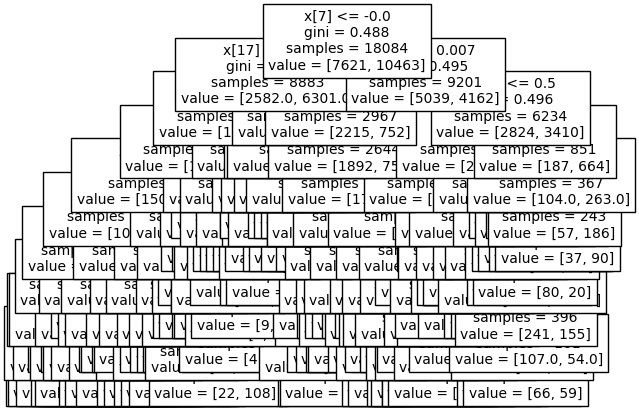

<Figure size 1000x600 with 0 Axes>

In [36]:
from sklearn import tree

tree.plot_tree(tree_model["dt"],fontsize=10)
plt.figure(figsize=(10,6))
plt.show()

From the tree visualization, features closest to the root, like `x[7]` and `x[17]`, are the most influential, because they split the largest number of samples. Likely candidate features may be `Supervision_Risk_Score_First`, `Gang_Affiliated`, `Age_at_Release`, `Prior Arrests`, or `Violations_ElectronicMonitoring_Yes`.

If the method above was not satisfactory, you can try visualizing all the rules of the decision tree as text. Is this any better?

In [37]:
from sklearn.tree import export_text
tree_rules = export_text(tree_model.named_steps['dt'], feature_names=list(tree_model.named_steps['ct'].get_feature_names_out()))
print(tree_rules)

|--- pipeline-1__Percent_Days_Employed <= -0.00
|   |--- pipeline-2__Age_at_Release_48 or older <= 0.50
|   |   |--- pipeline-2__Gang_Affiliated_Yes <= 0.50
|   |   |   |--- pipeline-2__Prior_Arrest_Episodes_Felony_1 <= 0.50
|   |   |   |   |--- pipeline-2__Prior_Arrest_Episodes_Misd_6 or more <= 0.50
|   |   |   |   |   |--- pipeline-1__Supervision_Risk_Score_First <= 0.19
|   |   |   |   |   |   |--- pipeline-1__Percent_Days_Employed <= -1.15
|   |   |   |   |   |   |   |--- pipeline-2__Prior_Conviction_Episodes_Misd_0 <= 0.50
|   |   |   |   |   |   |   |   |--- pipeline-2__Residence_Changes_0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- pipeline-1__Residence_PUMA <= -0.12
|   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |--- pipeline-1__Residence_PUMA >  -0.12
|   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |--- pipeline-2__Residence_Changes_0 >  0.50
|   |   |   |   |   |   |   |   |   |--- pipe

Yes, the text tree viz is better because even when the tree is extremely deep, you can scan top-level rules and repeated features to see what drives predictions. You can also trace individual sample predictions by following its path through the rules.

- Higher in the tree = stronger influence overall, because it splits more samples. The first feature is `pipeline-1__Percent_Days_Employed` <= -0.00. This means that employment history is the single most influential feature in deciding whether someone is predicted to recidivate. The next split is `pipeline-2__Age_at_Release_48` or `older <= 0.50`. Age is also important, especially at extremes. `pipeline-2__Gang_Affiliated_Yes` appears very early too, which shows that gang affiliation strongly affects the prediction.

- Features that repeatedly appear (even deeper in the tree) are also influential, although their impact is more localized and has moderate influence across many scenarios (`Prior_Arrest_Episodes_Felony_1`, `Prior_Arrest_Episodes_Misd_6 or more`, `Supervision_Risk_Score_First`, `DrugTests_Cocaine_Positive`)

- Leaf-only features (class: Yes/No) have minor influence; they affect only a few samples. Leaf nodes show the final decision after following the chain of rules from the root. The path a sample takes is essentially the combination of features that most influenced its prediction.

When it is not possible to interpret a decision tree because of its complex structure, we can still extract other information from it that will help us understand the features' importance in the decision. The code in the cell below extracts the feature importances from the model (line 3), then uses this information to create a bar plot of features sorted by importance. The feature importance extracted this way is based on [Gini Importance](https://www.codecademy.com/article/fe-feature-importance-final) (as it is done in the original paper), which reflects how the features were picked when building the decision tree.

<Axes: >

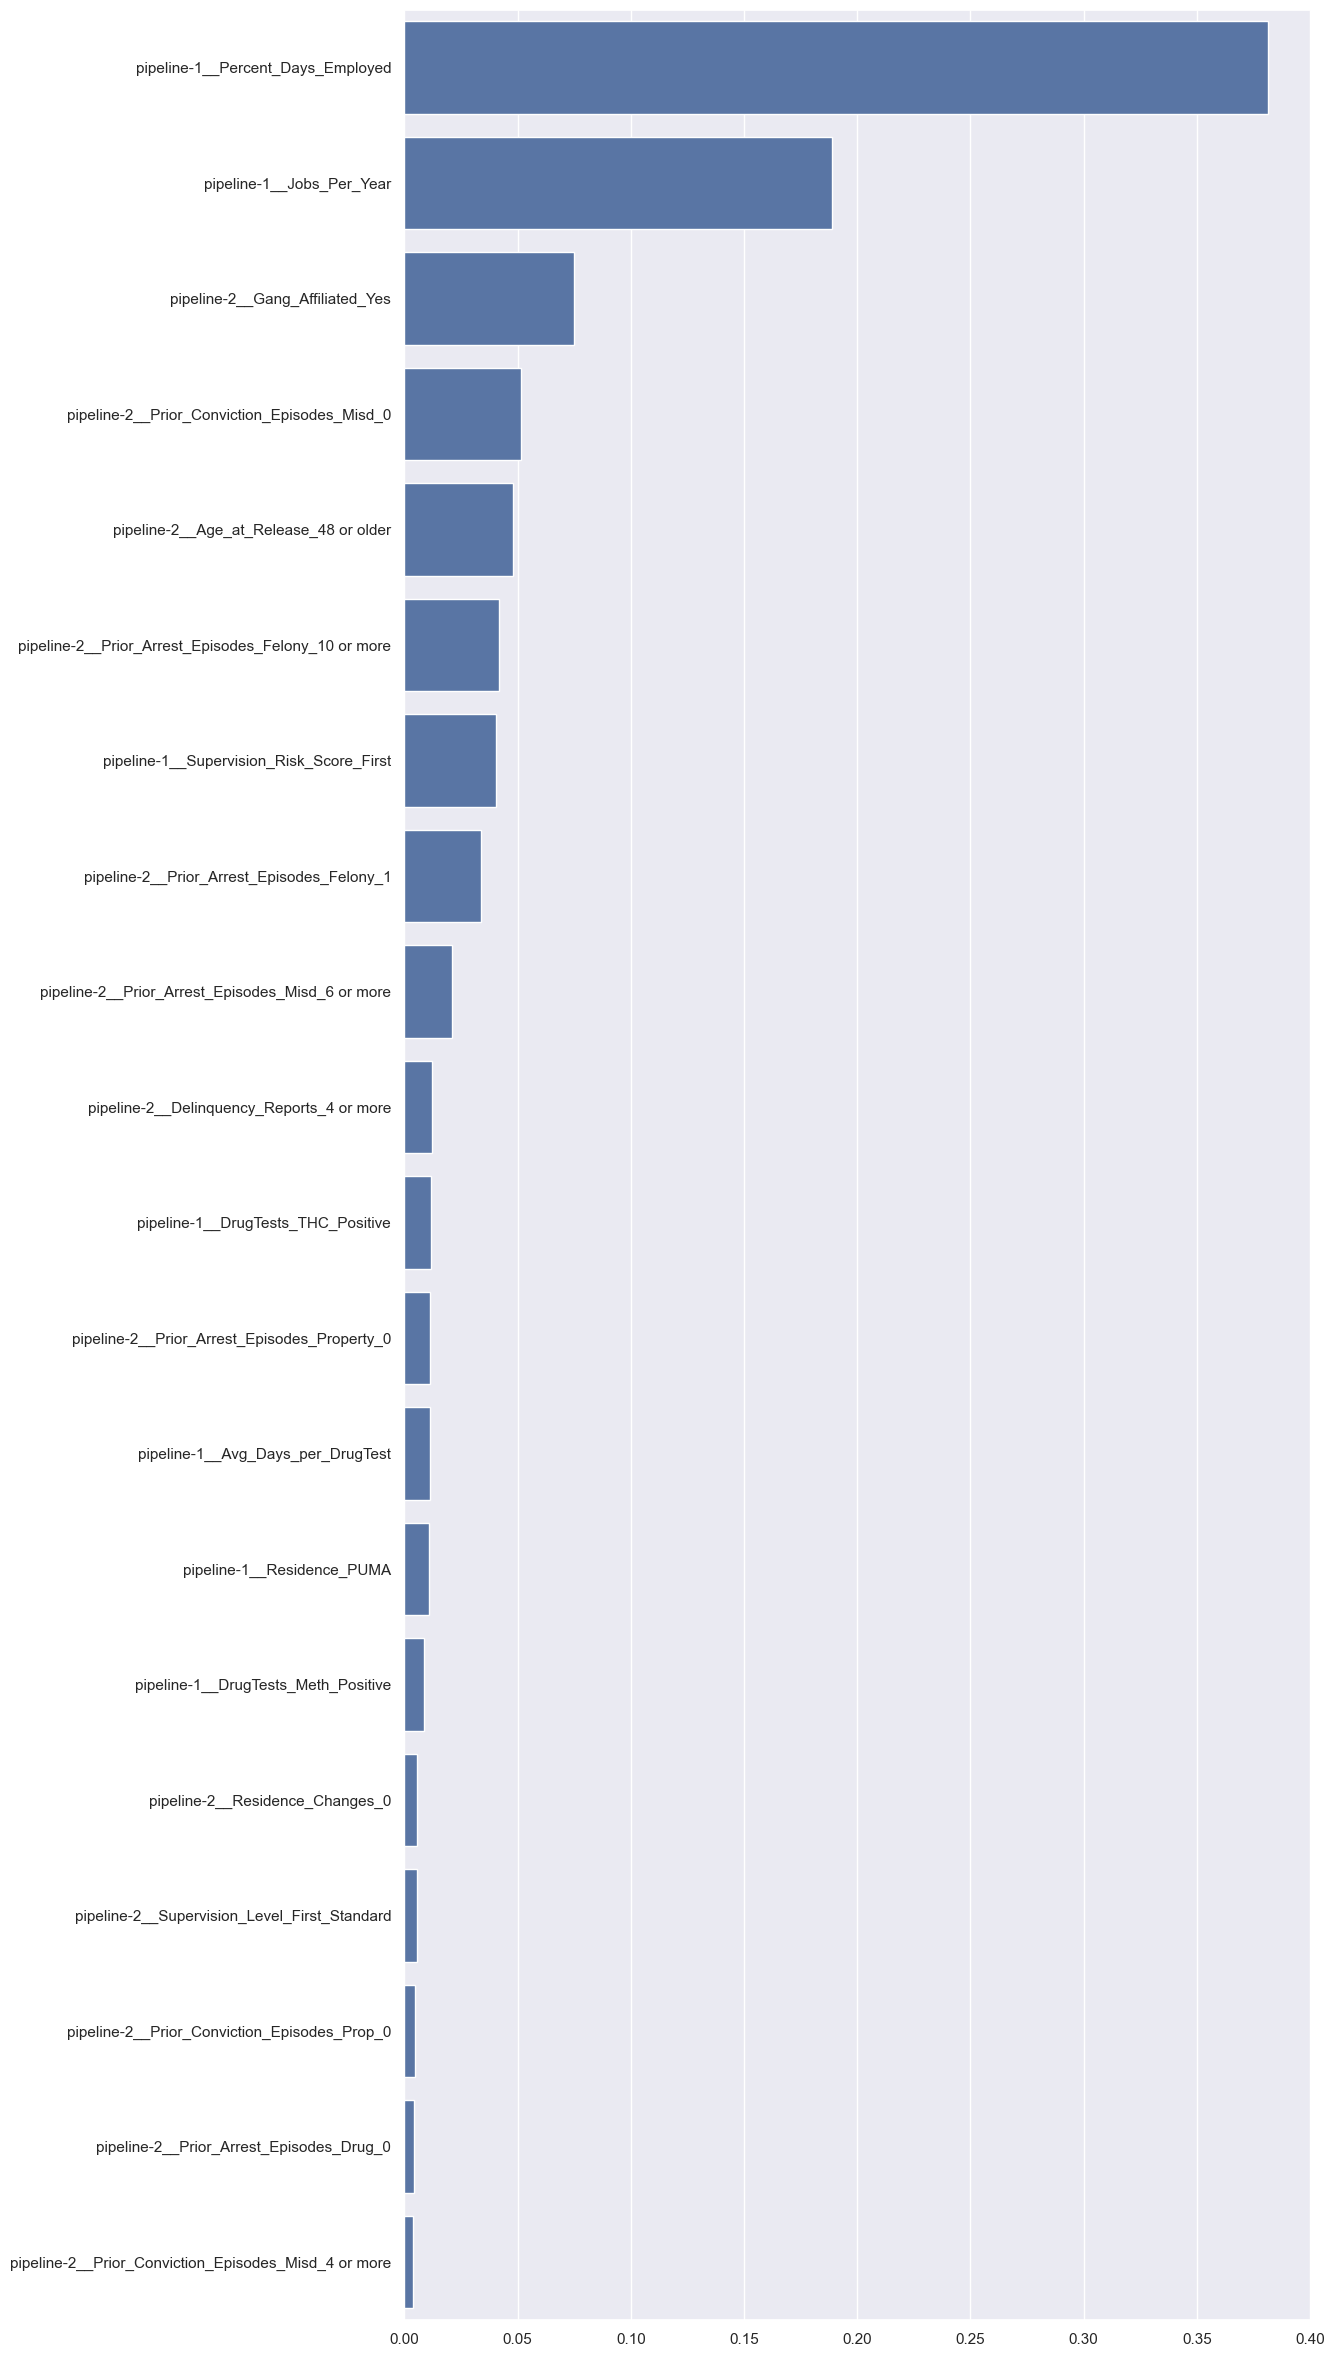

In [38]:
import seaborn as sns

feature_importances = tree_model.named_steps["dt"].feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = tree_model.named_steps['ct'].get_feature_names_out()[sorted_indices[0:20]] # Output limited to top 20 features
sorted_importances = feature_importances[sorted_indices[0:20]]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances, y=sorted_feature_names)

Comment on the features importance of the tree model, compared to those seen in the logistic regression model, as well as the original paper results. Also, **what is a big limitation of using feature importance, compared to observing the coefficient of the logistic regression model?**

- The top features in the decision tree, according to Gini importance, are:
    1.	`pipeline-1__Percent_Days_Employed` (~0.38) - the most important feature, indicating that the proportion of days someone was employed is the strongest predictor in the tree.
    2.	`pipeline-1__Jobs_Per_Year` (~0.20) – also highly influential, showing employment stability/frequency matters.
    3.	`pipeline-2__Gang_Affiliated_Yes` (~0.07) – less important, but still a noticeable factor.
    4.	`pipeline-2__Prior_Conviction_Episodes_Misd_0` (~0.05) – small influence, indicating prior misdemeanors have some predictive value.
    5.	Remaining features decrease gradually in importance, each contributing relatively little individually.
- Interpretation: The tree prioritizes features that best split the data at each node to reduce impurity (Gini). This means the tree "focuses" on features that separate the classes most effectively, not necessarily those with a linear or proportional effect.
-
- Logistic regression uses coefficients that directly indicate the strength and direction of the relationship between a feature and the outcome. For example, a positive coefficient = higher likelihood of the outcome; negative = lower likelihood.
- In contrast, feature importance in a tree only measures how much a feature contributed to reducing impurity across all splits. It does not indicate direction (positive or negative effect) or magnitude of effect on the outcome. For instance, you can see that `Percent_Days_Employed` is important, but you don’t know whether more days employed increases or decreases the predicted probability.
- Comparison to the original paper results: If the paper found similar top features (like employment-related metrics being most predictive), this aligns well. However, the exact ranking may differ because trees can emphasize interaction effects and non-linear splits, while logistic regression captures linear additive effects only.
-
- Limitation of Feature Importance: Lack of interpretability regarding direction and magnitude. Unlike logistic regression coefficients, tree-based feature importance does not tell you whether a feature increases or decreases the probability of the outcome, only that it helps the model split the data effectively. This makes it harder to reason about causality or policy decisions directly from tree feature importance.

### Question 13

As before, we are interested in evaluating how the model classifies a particular sample. Let's start looking at the classification for our `hard_sample`. Is it correct?

In [39]:
tree_model.predict(hard_sample)

array(['Yes'], dtype=object)

The decision tree predicted 'Yes' for `hard_sample`. This means that, according to the tree, the sample is classified as belonging to the positive class (Yes). 

Whether it's correct depends on the true label of `hard_sample`.

We would like to be able to tell what sequence of rules has led to this final decision, but, for a tree this large, this can be difficult, unless we want to manually sift through the list of rules or write some elaborate custom code. In the next sections, we will see an alternative method (SHAP) to achieve this result.

### Question 11: Evaluation of Non-inherently Interpretable Models Using a Surrogate Model

Models that are not inherently interpretable ("black box" models) can still be examined to understand how they used the available features to make their predictions. In fact, there are many strategies to do this. The first one we are going to see is through use of a **surrogate model.** In this case, we train another model - an inherently interpretable one, such as a logistic regressor - on the *predictions* of the black box model, and then we try to interpret *its parameters*. Let's complete the code below to do that on the 3 non-inherently interpretable models included in this exercise: Random Forest and XGBoost.

#### Surrogate for Random Forest Model

In [41]:
# Step 1: create logistic regressor object.
# For simplicity, we will use the already existing "NIJ_logreg.joblib" and re-train it, instead of creating
# a new one. The reason for this decision is that NIJ_logreg.joblib already knows how to handle the features
# of this dataset, while a new one will need to be designed to do so.

surrogate_model_rf = joblib.load("models_for_A3/NIJ_logreg.joblib")

# Step 2: train model on random forest predictions on the training set
y_pred_rf_train = rf_model.predict(X_train)
surrogate_model_rf.fit(X_train, y_pred_rf_train)

# Step 3: visualize weights of surrogate model, as we did for the original logistic regression model
eli5.explain_weights(surrogate_model_rf[-1], feature_names=surrogate_model_rf[:-1].get_feature_names_out())

Weight?,Feature
+1.084,pipeline-2__Age_at_Release_18-22
+0.937,pipeline-2__Gang_Affiliated_Yes
+0.716,pipeline-2__Delinquency_Reports_1
+0.640,pipeline-2__Prior_Arrest_Episodes_Felony_10 or more
+0.575,pipeline-2__Age_at_Release_23-27
+0.455,pipeline-2__Prior_Arrest_Episodes_Misd_6 or more
+0.441,pipeline-2__Gender_M
+0.405,pipeline-2__Prior_Revocations_Parole_Yes
+0.388,pipeline-2__Violations_ElectronicMonitoring_Yes
+0.365,pipeline-2__Condition_MH_SA_Yes


Now that we have the weights of the surrogate model, what can we say about how the Random Forest model makes its predictions? What features seem more important? Are they similar to what we have seen for the other models so far?

- The surrogate logistic regression is trained on the predictions of the Random Forest. Its coefficients (weights) indicate how strongly each feature is associated with predicting a "Yes" according to the RF model: Positive weight = increases likelihood of "Yes", Negative weight = decreases likelihood of "Yes". This allows us to approximate the black box model in an interpretable way.

- Looking at the largest positive weights:
	1.	`pipeline-2__Age_at_Release_18-22` (+1.084) -> younger individuals at release are most strongly associated with "Yes" predictions.
	2.	`pipeline-2__Gang_Affiliated_Yes` (+0.937) -> gang affiliation strongly increases predicted "Yes".
	3.	`pipeline-2__Delinquency_Reports_1` (+0.716) -> some prior delinquency reports also increase "Yes".
	4.	`pipeline-2__Prior_Arrest_Episodes_Felony_10` or more (+0.640) -> extensive felony history contributes to "Yes".
	5.	Additional positive weights include age 23–27, high misdemeanor counts, male gender, parole revocations, and certain mental health/substance abuse conditions.
- Interpretation: The RF model seems to emphasize demographics (age, gender), criminal history (arrests, prior reports), and gang affiliation when predicting risk (Yes).

- Looking at the largest negative weights:
    - `pipeline-1__Percent_Days_Employed` (-0.929) -> higher employment reduces predicted "Yes" (makes sense intuitively).
    - `pipeline-2__Age_at_Release_48` or older (-0.911) -> older individuals are less likely predicted as "Yes".
    - Other negative weights: low criminal activity, fewer felony/misdemeanor episodes, and high program participation.
- Interpretation: Protective factors like employment, older age, and engagement in programs reduce predicted risk in the RF model.

- Comparison to other models: `Percent_Days_Employed` is less important in RF than in the decision tree, suggesting the RF considers more complex interactions with age, gang affiliation, and criminal history. All models consistently identify age, criminal history, and gang affiliation as key predictors.

- The RF model’s predictions can be approximated with an interpretable surrogate, revealing which features drive its decisions.
- Key patterns:
    - Younger age, gang affiliation, and prior offenses -> increase risk (Yes)
    - Higher employment, older age, program participation -> decrease risk (No)
- Advantage: Surrogate analysis helps explain black-box predictions without needing to manually trace thousands of tree splits.

**Note:** using a surrogate model is not always a very good strategy, because the simpler "white box" model is often unable to replicate the behavior of the most complex "black box" model. We can get a sense of how close the surrogate is approximating the original model by looking at the R<sup>2</sup> score. In the paper, they do so when trying to create a surrogate for XGBoost, and they explain: 

*The R<sup>2</sup> value between the XGBoost predictions and the surrogate model predictions on the test set is 0.38. The surrogate model only explains 38% of the variance in the XGBoost model’s predictions*

Test this for the random forest surrogate model. How much variance is it able to capture?

**Hints:**
- Think carefully about what constitues the array of predictions and the array of ground truths in this case
- You may remember that R<sup>2</sup> is, in fact, a metric for regression, not for classification! How can we use R<sup>2</sup> in this case? There are various ways to approximate R<sup>2</sup> for classification, as explained [here](https://datascience.oneoffcoder.com/psuedo-r-squared-logistic-regression.html). We will use the simplest one and use **count R<sup>2</sup>**, which is simply the accuracy of the surrogate classifier

In [44]:
from sklearn.metrics import r2_score
surrogate_pred = surrogate_model_rf.predict(X_train)

# compute count R2 
accuracy_score(y_pred_rf_train, surrogate_pred)
count_r2 = accuracy_score(y_pred_rf_train, surrogate_pred)
count_r2


0.7528754700287547

Interpretation: The surrogate explains 75% of the variance in RF predictions, which is pretty good.

Now, repeat the analysis through surrogate model for XGBoost. Comment on the results, including considerations on the following:
- What seem to be the most important features?
- How do the sets of most important features compare across models (do not forget logistic regression and decision tree in this comparison)?
- How good are the surrogate models, in terms of capturing the variance of the original model? Are they reliable?
- ...more thoughts of your choice...

#### Surrogate for XGBoost Model

In [46]:
# Load the same logistic regression pipeline
surrogate_model_xgb = joblib.load("models_for_A3/NIJ_logreg.joblib")

# Train it on XGBoost predictions
y_pred_xgb_train = xgboost_model.predict(X_train)
surrogate_model_xgb.fit(X_train, y_pred_xgb_train)

# Visualize feature weights
eli5.explain_weights(
    surrogate_model_xgb[-1], 
    feature_names=surrogate_model_xgb[:-1].get_feature_names_out()
)

Weight?,Feature
+1.888,pipeline-2__Gang_Affiliated_Yes
+1.722,pipeline-2__Age_at_Release_18-22
+1.306,pipeline-2__Prior_Arrest_Episodes_Felony_10 or more
+1.105,pipeline-2__Delinquency_Reports_1
+1.058,pipeline-2__Gender_M
+1.050,pipeline-2__Age_at_Release_23-27
+0.824,pipeline-2__Prison_Years_Less than 1 year
+0.824,pipeline-1__Jobs_Per_Year
+0.794,pipeline-2__Prior_Arrest_Episodes_Felony_0
+0.745,pipeline-2__Condition_MH_SA_Yes


**Most important positive features (y=1 -> "Yes")**
- Gang affiliation (+1.888) -> being gang-affiliated is the single strongest predictor of a "Yes" outcome.
- Young age at release (+1.722, 18–22) -> very young individuals are at higher risk.
- Prior felony arrests 10+ (+1.306) -> heavy criminal history increases predicted risk.
- Delinquency reports (+1.105, 1 report) -> even a small record matters.
- Male gender (+1.058) -> males are more likely to be predicted "Yes".
- Age 23–27 (+1.050) -> slightly older youth also at higher risk.
- Other notable positive contributors: short prison sentences (<1 year), number of jobs per year, mental health/substance abuse conditions, misdemeanor arrests, violations of instructions.
- Interpretation: XGBoost heavily emphasizes demographics (age, gender), gang affiliation, and prior criminal history for predicting "Yes" outcomes.

**Most important negative features (y=0 -> "No")**
- Older age at release (48+ -> -1.920) -> older individuals much less likely to be predicted "Yes".
- Percent days employed (-1.919) → higher employment is strongly protective.
- Prior felony arrests (1) -> -1.563 -> minimal criminal history reduces risk.
- Program attendance 10+ (-0.922) -> engagement in programs reduces risk.
- Delinquency reports 4+ (-1.184) -> interestingly, very high reports may push predictions to "No" in some complex interaction scenarios (possibly because age/employment interactions matter).
- Interpretation: Protective factors include older age, higher employment, program participation, and minimal criminal history.

**Comparison**
| Model                     | Top "Yes" predictors                                | Notes                                                          |
|---------------------------|-----------------------------------------------------|----------------------------------------------------------------|
| Decision Tree             | Percent_Days_Employed, Jobs_Per_Year, Gang_Affiliated_Yes | Focused on employment splits                                   |
| Logistic Regression       | Age, prior arrests, gang affiliation, employment   | Linear, additive effects                                       |
| Random Forest (surrogate) | Age 18–22, gang affiliation, felony counts, delinquency | Captures interactions, top features align with LR             |
| XGBoost (surrogate)       | Gang affiliation, age 18–22, felony arrests, delinquency, gender | Even stronger emphasis on gang affiliation and young age; interactions captured |

- Across all models, age, criminal history, gang affiliation, and employment consistently emerge as most predictive.
- XGBoost and Random Forest surrogates highlight interactions more clearly (e.g., gang + young age).
- Decision tree emphasizes employment features more than age.
- Logistic regression provides interpretable coefficients but can miss non-linear interactions.

**How good is the surrogate?**
- From the paper, XGBoost surrogate R² = ~0.38 -> explains 38% of variance in XGBoost predictions.
- This is much lower than Random Forest surrogate, indicating that the surrogate cannot fully replicate XGBoost’s complex behaviour.
- Surrogate still useful for high-level feature importance, but not for exact predictions or understanding detailed interactions.

**More thoughts**
- Gang affiliation dominates for XGBoost, more than RF surrogate. This may reflect XGBoost’s ability to capture subtle splits that strongly amplify this effect.
- Employment remains protective across all models, but trees emphasize it more, whereas XGBoost uses it in combination with age and criminal history.
- Surrogates are a first step for interpretability, but using SHAP values would give per-sample explanations and better account for interactions.


### Question 12: Evaluation of Non-inherently Interpretable Models Using Permutation Feature Importance

Another method used to interpret black box models is using feature permutation, which means changing the value of a feature and observing changes in the model's prediction error. More important features, when changed, will result in more frequent mistakes.

Luckily for us, Permutation Feature Importance already exists as a function in Scikit-Learn! All you have to do it is looking at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) to learn how it works, and apply it to the 3 non-inherently interpretable models of this exercise. Let's start with Random Forest.

#### Random Forest Model:

In [47]:
# Use permutation_importance on the random forest model, and save the result in a variable called "out"
out = permutation_importance(rf_model, X_test, y_test, random_state=0)

After you are done, you can run the cell below to visualize the top 5 most important features in a bar chart. If you like, you can change the number of features shown or try other visualization methods.

<Axes: xlabel='Importance', ylabel='Name'>

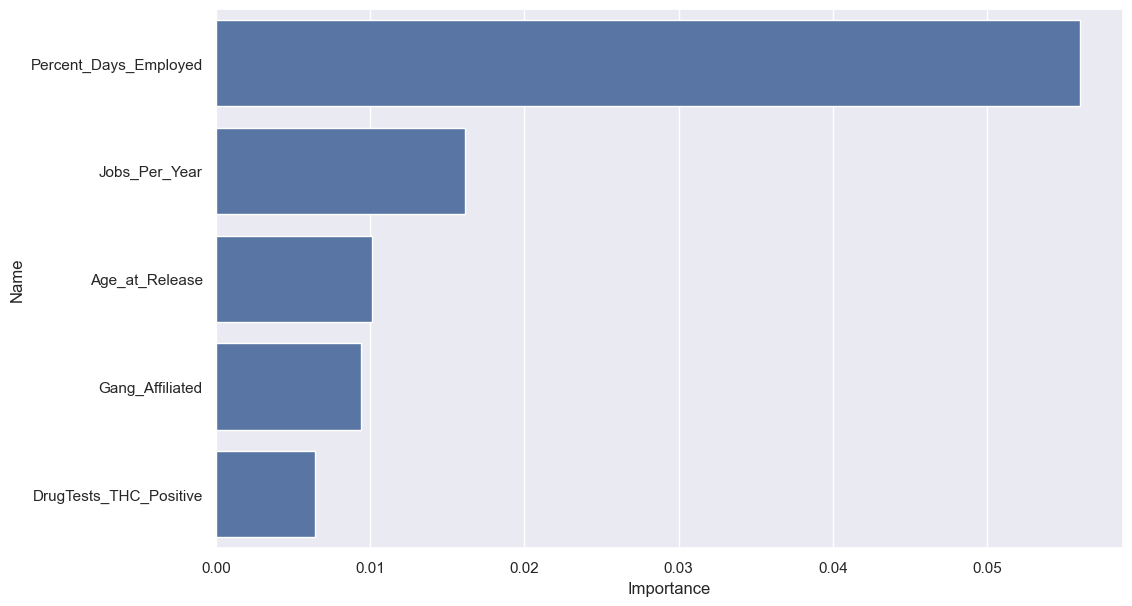

In [54]:
result = pd.DataFrame({"Name": X_test.columns, "Importance": out["importances_mean"], "STD": out["importances_std"]})
result = result.sort_values(by=['Importance'], ascending=False)

sns.set(rc={'figure.figsize':(11.7,7)})
sns.barplot(data=result[:5], y="Name", x="Importance")

**How permutation importance works**
- Each feature is shuffled randomly across the test set, one at a time.
- The model makes predictions on this perturbed data.
- Important features: shuffling them breaks the model’s performance (accuracy drops significantly).
- Less important features: shuffling has little effect.
- So, the higher the importance value, the more the model depends on that feature for correct predictions.

**Observed top features**
- Percent_Days_Employed - >0.05 -> Most important: Random Forest relies heavily on employment consistency.
- Jobs_Per_Year - ~0.02 -> Employment stability also matters, but less than overall employment.
- Age_at_Release - 0.01 -> Younger age increases risk, though effect is smaller than employment.
- Gang_Affiliated - just under 0.01 -> Gang membership contributes, but Random Forest considers employment more critical.
- DrugTests_THC_Positive - ~0.005 -> Minor effect; shuffling barely impacts predictions.

**Interpretation:**
- The Random Forest is most sensitive to employment features, then age, gang affiliation, and finally drug tests.
- This matches the decision tree’s pattern, where employment was highly important.
- Permutation importance gives a direct sense of how model performance is affected, unlike Gini importance, which only measures split impurity.

**Key insight:**
- Permutation importance aligns more with the tree model than the surrogate, highlighting employment features as critical for correct classification.
- Surrogate models show which features influence the black box’s decisions, but permutation importance shows which features actually impact prediction performance.

Now, use Permutation Feature Importance on XGBoost.

**Hint:** these are more complex models; if you find that this task is taking too long, you may consider reducing the number of permutations using the parameter `n_repeats`. Be aware that this produces more variable results.

#### XGBoost Model:

In [50]:
# Your solution here

# from sklearn.inspection import permutation_importance
# import pandas as pd
# import seaborn as sns

# Run permutation importance on XGBoost
# Reduce n_repeats to speed up if needed (default is 5)
out_xgb = permutation_importance(
    xgboost_model, 
    X_test, 
    y_test, 
    n_repeats=5,       # fewer repeats = faster but slightly noisier
    random_state=0
)

# Convert to DataFrame for easy visualization
result_xgb = pd.DataFrame({
    "Name": X_test.columns, 
    "Importance": out_xgb["importances_mean"], 
    "STD": out_xgb["importances_std"]
})

# Sort by importance
result_xgb = result_xgb.sort_values(by="Importance", ascending=False)

# Visualize top 5 features
sns.set(rc={'figure.figsize':(11.7,7)})
sns.barplot(data=result_xgb[:5], y="Name", x="Importance")

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=['No' 'Yes'] and y_pred=[0 1]. Make sure that the predictions provided by the classifier coincides with the true labels.

Now that you have completed your analysis of feature importance using permutation, comment on the results. How do the sets of most important features compare with each other? Are this results similar to what you observed using the surrogate model?

### Question 13: Evaluation of Non-inherently Interpretable Models Using SHAP

The last method we are going to use to interpret the impact of each feature in our model is called SHAP, which stands for SHapley Additive exPlanations. How SHAP works is beyond the scope of this course, but if you are curious you can read the [original paper](https://arxiv.org/pdf/1705.07874.pdf) by Lundberg and Lee and check out [Lundberg's GitHub repo](https://github.com/shap/shap), which provides details on the implementation and examples.

You will need to install SHAP to be able to use it:
```
pip install shap
or
conda install -c conda-forge shap
```

Then, import it:

In [56]:
# pip install shap

In [51]:
import shap # may require to downgrade numpy to version = 1.23
shap.initjs()

/opt/miniconda3/envs/dsci430/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP needs the model (we will start with Random Forest) and samples to use to explain the predictions. For this, we will need to give it transformed samples (scaled and imputed, as required by the model) from  `X_train` or `X_test`.

In [52]:
X_train_enc = pd.DataFrame(
    data=rf_model.named_steps['ct'].transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=rf_model.named_steps['ct'].transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

ind = np.random.choice(len(X_test_enc) - 1, 1000)  
# This line just gives 1000 random indexes from the training set
# We do this because getting SHAP values for all samples would be a bit too long, but you 
# are free to try it out!

ind = np.append(ind, 5) # adding the hard sample - we'll need this later

The following lines are all that's needed to explain the model's predictions for a set of samples:

In [53]:
rf_explainer = shap.TreeExplainer(rf_model[-1])  # creating SHAP Explainer based on the model

rf_shap_values = rf_explainer.shap_values(X_test_enc.iloc[ind])  # explaining predictions for 1000 random samples

This gives us the SHAP values for each sample and each feature (values for the positive class):

In [54]:
rf_shap_values[:,:,1]

array([[ 9.10639383e-03,  2.87750737e-02, -3.21309243e-03, ...,
        -5.28961529e-04, -3.08372329e-04, -8.06223564e-04],
       [ 5.09071095e-03,  3.21323764e-02, -6.40145516e-03, ...,
        -1.11351534e-03,  5.74498404e-04, -5.17458079e-05],
       [ 2.65601364e-03,  1.97997446e-02, -1.14065487e-02, ...,
        -1.03344935e-03,  8.55882839e-04,  1.80041737e-04],
       ...,
       [-4.72733233e-03,  2.81115894e-02, -4.69059953e-03, ...,
         1.39935287e-02,  6.16844618e-03, -6.66799861e-04],
       [ 1.35325449e-03,  3.04326196e-02, -4.66042802e-03, ...,
         3.37327190e-03, -5.93957235e-04, -5.57081537e-04],
       [ 9.75082769e-03,  3.00911588e-02, -5.79172209e-03, ...,
        -6.66894403e-04,  3.32116897e-04,  2.57025881e-03]],
      shape=(1001, 124))

This is hardly interpretable, though. It is better to get the average values for each feature, which returns something similar to feature importance:

In [55]:
values = np.abs(rf_shap_values[:,:,1]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
pipeline-1__Percent_Days_Employed,0.070138
pipeline-2__Gang_Affiliated_Yes,0.032144
pipeline-1__DrugTests_THC_Positive,0.030105
pipeline-1__Supervision_Risk_Score_First,0.024132
pipeline-1__Jobs_Per_Year,0.022484
pipeline-2__Prior_Arrest_Episodes_Misd_6 or more,0.017069
pipeline-2__Age_at_Release_48 or older,0.017030
pipeline-2__Prior_Conviction_Episodes_Misd_0,0.015247
pipeline-1__DrugTests_Meth_Positive,0.010677
pipeline-2__Prior_Conviction_Episodes_Misd_4 or more,0.010672


The SHAP library also has a lot of ways to visualize and interpret the SHAP values - try it out!

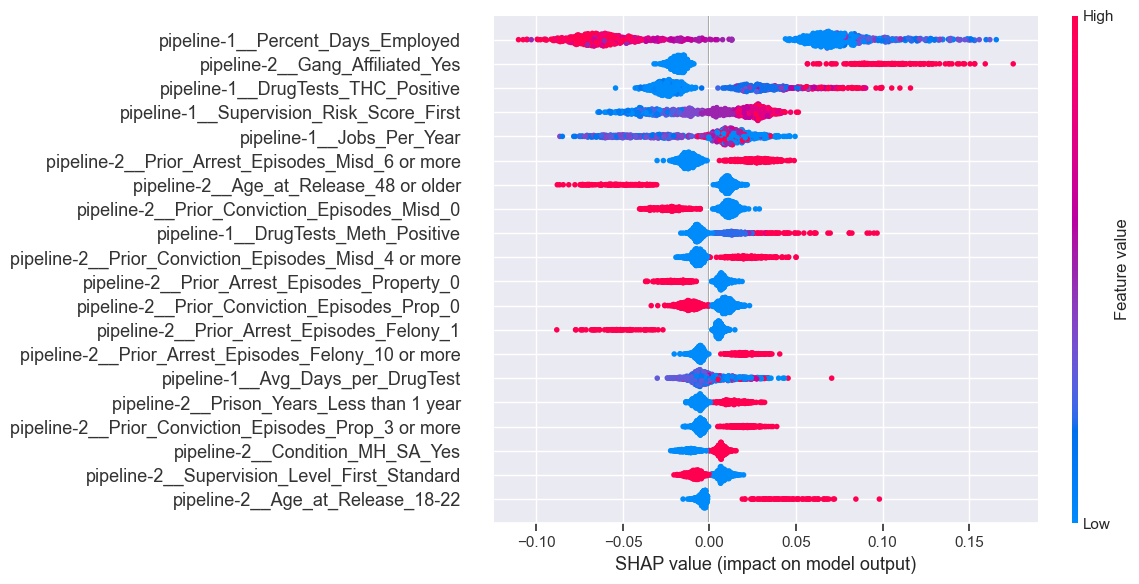

In [56]:
shap_figure = shap.summary_plot(rf_shap_values[:, :, 1], X_test_enc.iloc[ind], plot_size=[12,6])

Given the new information obtained using the SHAP library on the Random Forest model, explain the results (you will need to refer to the SHAP documentation - or ask us for help interpreting the plots) and comment on the difference between these results and those obtained using the other methods.



Next, **repeat this analysis for XGBoost.**

In [57]:
# Your solution here

ind = np.random.choice(len(X_test_enc) - 1, 1000, replace=False)
ind = np.append(ind, 5)  # include your "hard sample"

xgb_explainer = shap.TreeExplainer(xgboost_model)

xgb_shap_values = xgb_explainer.shap_values(X_test_enc.iloc[ind])

if len(xgb_shap_values.shape) == 3:
    values = np.abs(xgb_shap_values[:, :, 1]).mean(0)
else:
    values = np.abs(xgb_shap_values).mean(0)

shap_df = pd.DataFrame(data=values, index=feature_names, columns=["SHAP"])
shap_df.sort_values(by="SHAP", ascending=False)[:10]

shap.summary_plot(
    xgb_shap_values[:, :, 1] if len(xgb_shap_values.shape) == 3 else xgb_shap_values, 
    X_test_enc.iloc[ind], 
    plot_size=[12,6]
)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>

### Question 14: Explaining individual predictions using SHAP

Another powerful feature of SHAP is that it allows us to explain the impact of each feature on individual predictions. For example, we will be able to explain how the prediction for our hard sample was generated. Let's start by looking at the prediction for this sample given by the random forest model. **Is it correct?**

In [ ]:
rf_model.predict(hard_sample)

NameError: name 'hard_sample' is not defined

Let's look at the **force plot** for this particular prediction, by running the cell below:

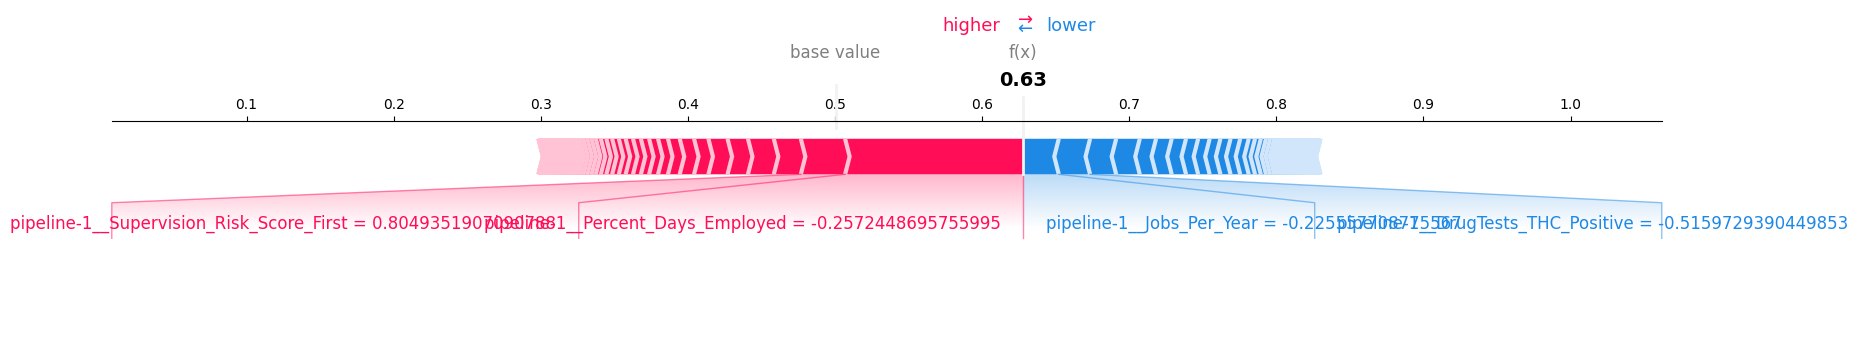

In [ ]:
shap.force_plot(
    rf_explainer.expected_value[1],
    rf_shap_values[:,:,1][-1],
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
)

**Interpret the plot results,**, including the following:
- What contributed the most to the prediction?
- What countered the prediction the most?
- Can we tell, by looking at the plot, that this was a difficult prediction?

**1. What contributed the most to the prediction?**
- The features in red are pushing the prediction higher (closer to 1.0).
- Primary Driver: The feature `pipeline-1__Supervision_Risk_Score_First` with a value of 0.805 is the most significant contributor. The width of its red bar indicates it has the largest "force" pushing the probability upward.
- Secondary Driver: `pipeline-1__Percent_Days_Employed` (value: -0.257) also contributes to increasing the prediction, though to a lesser extent.

**2. What countered the prediction the most?**
- The features in blue are pushing the prediction lower (closer to 0.0).
- Primary Counter-force: `pipeline-1__Drug_Tests_THC_Positive` (value: -0.516) is the strongest force pulling the prediction down.
- Secondary Counter-force: `pipeline-1__Jobs_Per_Year` (value: -0.226) also works to lower the final score.

**3. Was this a difficult prediction?**
- Yes, this appears to be a "difficult" or highly contested prediction for the model. This is because there is a large amount of both red and blue, which indicates that the model is seeing strong evidence for both a high score and a low score simultaneously. Also, the final output (`f(x) = 0.63`) is relatively close to the decision boundary (likely 0.5) compared to the base value (roughly 0.5). So, at only a moderate distance, the model likely has low certainty.

Finally, **repeat the analysis and comment on the results of the individual predictions made on the hard sample by XGBoost and Decision Tree** (since we were not able to do the latter earlier).

In [ ]:
# Your answer here


# Part 5: Final Evaluation:

### Question 15

Using **all the results collected so far** on accuracy, fairness and transparency of the 5 model, write your recommendation about what model, in your opinion, should be employed for this application (300 words max).

# Final thoughts

1) If you have completed this assignment in a group, please write a detailed description of how you divided the work and how you helped each other completing it:

mixed answers

2) Have you used ChatGPT or a similar Large Language Model (LLM) to complete this homework? Please describe how you used the tool. We will never deduct points for using LLMs for completing homework assignments, but this helps us understand how you are using the tool and advise you in case we believe you are using it incorrectly.

aid in struggles or formatting

3) Have you struggled with some parts (or all) of this homework? Do you have pending questions you would like to ask? Write them down here!

SHAP